# Convolutional Neural Network trained on handwritten Devanagari script characters

I have constructed a Convolutional Neural Network that is trained to classify characters from the Devangari (Hindi) script. There are exactly 92 thousand images of 32x32 px resolution, that include the the consonants "ka" to "gya", and the digits, 0 to 9. The vowels are not considered in the dataset here. This dataset is taken from https://www.kaggle.com/rishianand/devanagari-character-set
and the dataset is in 2 formats, one a csv file and another an archive of images. Since the csv file is neatly formatted without issues, I will only be using the csv file for model training.

The process I followed can be split into 4 parts:
* Data preprocessing and segregation 
* Model Architecture design
* Model Training
* Progress and accuracy visualization

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# import csv file dataset
# this dataset consists of handwritten character data in the form of a 32x32 pixel array, converted into csv
dataset = pd.read_csv("data.csv")

In [3]:
#display dataset
dataset.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


I use iloc on the pandas dataframe to select data by position, using integer based indexing.

In [4]:
Pixels = dataset.iloc[:,:-1]
all_labels = dataset.iloc[:,-1]

In [5]:
#number of pixels
number_of_pixels = Pixels.shape[1] # number of pixels = 32*32 = 1024
num_classes = 46 #number of classes = ('ka' to 'gya') + (0 to 9) = 36 + 10
img_width = 32 #pixels
img_height = 32
img_depth = 1 # the image is in greyscale, hence img_depth is set to 1. In the case of an RGB image, it would be 3, and for CMYK images it would be 4.

In [6]:
Images = Pixels.values.reshape(Pixels.shape[0], img_width, img_height) #gives a new shape to array without chaging the values of the data

Here's an example of how each image is represented on average:

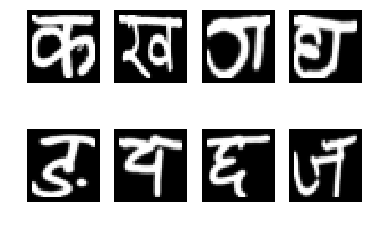

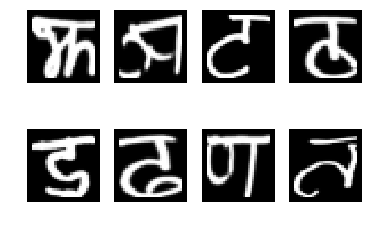

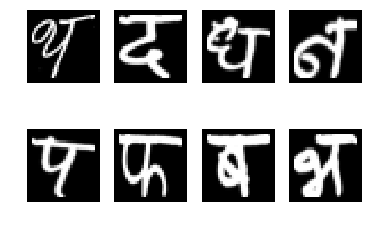

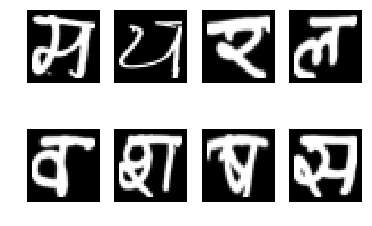

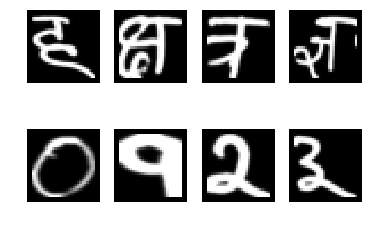

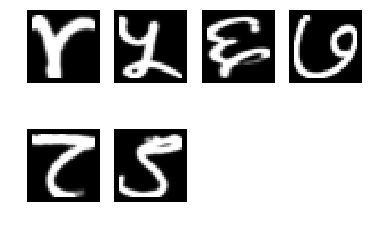

In [7]:
#displaying an example of each character
for i in range(1, 9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(Images[(i*2000)-1], cmap=plt.get_cmap('gray'))
plt.show()
for i in range(9, 17):
    plt.subplot(240+i-8)
    plt.axis('off')
    plt.imshow(Images[(i*2000)-1], cmap=plt.get_cmap('gray'))
plt.show()
for i in range(17, 25):
    plt.subplot(240+i-16)
    plt.axis('off')
    plt.imshow(Images[(i*2000)-1], cmap=plt.get_cmap('gray'))
plt.show()
for i in range(25, 33):
    plt.subplot(240+i-24)
    plt.axis('off')
    plt.imshow(Images[(i*2000)-1], cmap=plt.get_cmap('gray'))
plt.show()
for i in range(33, 41):
    plt.subplot(240+i-32)
    plt.axis('off')
    plt.imshow(Images[(i*2000)-1], cmap=plt.get_cmap('gray'))
plt.show()
for i in range(41, 47):
    plt.subplot(240+i-40)
    plt.axis('off')
    plt.imshow(Images[(i*2000)-1], cmap=plt.get_cmap('gray'))
plt.show()

I have used one hot encoding to convert the labels into binary arrays with the value specific label valued index set to 1, while the rest of the values of each binary array are set to 0

In [8]:
labels = list(set(dataset.iloc[:,-1]))
labels.sort()
labels

['character_01_ka',
 'character_02_kha',
 'character_03_ga',
 'character_04_gha',
 'character_05_kna',
 'character_06_cha',
 'character_07_chha',
 'character_08_ja',
 'character_09_jha',
 'character_10_yna',
 'character_11_taamatar',
 'character_12_thaa',
 'character_13_daa',
 'character_14_dhaa',
 'character_15_adna',
 'character_16_tabala',
 'character_17_tha',
 'character_18_da',
 'character_19_dha',
 'character_20_na',
 'character_21_pa',
 'character_22_pha',
 'character_23_ba',
 'character_24_bha',
 'character_25_ma',
 'character_26_yaw',
 'character_27_ra',
 'character_28_la',
 'character_29_waw',
 'character_30_motosaw',
 'character_31_petchiryakha',
 'character_32_patalosaw',
 'character_33_ha',
 'character_34_chhya',
 'character_35_tra',
 'character_36_gya',
 'digit_0',
 'digit_1',
 'digit_2',
 'digit_3',
 'digit_4',
 'digit_5',
 'digit_6',
 'digit_7',
 'digit_8',
 'digit_9']

For example, the unique dataset labels get one-hot encoded to the following arrays:

In [9]:
one_hot_labels = np.eye(num_classes)[range(0,len(labels))]
list(one_hot_labels)

[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

In [10]:
all_label_indices = []
for i in range(len(all_labels)):
    all_label_indices.append(labels.index(all_labels[i]))

In [11]:
onehot_encoded_labels = np.eye(num_classes)[all_label_indices]
onehot_encoded_labels

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

Seperating the training and testing data. I have reserved 20% of the total data to be used for testing the final trained model.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Images, onehot_encoded_labels, test_size=0.20)

In [13]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, img_depth).astype('float32')
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, img_depth).astype('float32')

I'll now reduce the range of each pixel value from 0:255 to a decimal value between 0 and 1.

I had earlier faced an issue here where I was losing valuable pixel data at the time of pixel scaling. I had been using an integer datatype instead of float, and although the model was training with significant accuracy, I was getting extremely low accuracy when providing my model with fresh new handwritten data via the user facing frontend application that I built for this specific purpose. 

In [14]:
X_train = X_train/255
X_test = X_test/255

We will be using an accuracy metric to train the model, by checkpointing those trained model weights that improve upon the validation accuracy. This will ensure that the model does not overfit, as maximizing the validation accuracy essentially means that we are measuring the model's ability to accurately recognize unseen data.

I was also facing an issue here where without the checkpointing in place, my model was fluctuating between a range of accuracies and was seemingly not improving even after a significant number of epochs. Checkpointing enabled preservation of validation accuracy and a general prevention of overfitting.

In [15]:
model = Sequential()
model.add(Conv2D(50, 4, input_shape=(img_height, img_width, img_depth), activation='relu')) # input layer
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(100, 4, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # output layer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


The process by which CNN's are trained is called backpropagation. A model is essentially a mathematical representation of data, with each node referring to a simple function that takes n inputs, places multiplicative weights on each of those inputs, sums the resultant and passes it through the function to produce an output.

The training phase involves passing the inputs one by one through the network and comparing the recieved output with that of the expected output. Then the neural network's weights are tweaked by a small factor each, so as to make the model come closer to 100% accuracy. The CNN's weights are tweaked in a reverse fashion, starting with the furthest connected neuron pairs from the input layer, and then the second furthest and so on. This process is executed for each input. Once all inputs have been passed through this algorithm, we can say that the model has been trained for one epoch. Neural networks are usually trained for multiple epochs. If we use a checkpointer, we can guarantee that per epoch, only the models with the best validation accuracy will remain preserved. Thereby minimizing any chances of overfitting to occur.

The model essentially consists of 3 hidden layers, 1 input layer and 1 output layer. 
After the first input layer, we have 2 convolution layers with 50 and 100 neurons respectively. The convolution layer is specially designed to process spatial data, and is sensitive to data pixels that are closer to each other spatially. 

The outputs of these layers are passed through a Maxpooling function that esentially downsamples the output from the convolution layer by returning the brightest (highest bit valued) pixel from each 2x2 pixel window tweened across the input pixel map.

The final layer before the output layer is a densely connected layer that consists of 200 neurons. It is provided a flattened single dimensional input from the second layer.

The final densely connected layer contains exactly as many neurons as there are classes to be detected.

In [16]:
checkpointer = ModelCheckpoint(filepath='basic_cnn_10_epochs23.h5',verbose=1,save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.15, epochs=10, batch_size = 184, verbose=1,shuffle=True, callbacks=[checkpointer])

Train on 62560 samples, validate on 11040 samples
Epoch 1/10
62560/62560 [==============================] - 440s - loss: 0.8798 - acc: 0.7573 - val_loss: 0.2789 - val_acc: 0.9178
Epoch 2/10
62560/62560 [==============================] - 668s - loss: 0.2345 - acc: 0.9302 - val_loss: 0.1842 - val_acc: 0.9445
Epoch 3/10
62560/62560 [==============================] - 665s - loss: 0.1483 - acc: 0.9543 - val_loss: 0.1294 - val_acc: 0.9609
Epoch 4/10
62560/62560 [==============================] - 681s - loss: 0.1047 - acc: 0.9673 - val_loss: 0.1069 - val_acc: 0.9673
Epoch 5/10
62560/62560 [==============================] - 414s - loss: 0.0782 - acc: 0.9751 - val_loss: 0.1086 - val_acc: 0.9674
Epoch 6/10
62560/62560 [==============================] - 255s - loss: 0.0618 - acc: 0.9805 - val_loss: 0.0900 - val_acc: 0.9738
Epoch 7/10
62560/62560 [==============================] - 278s - loss: 0.0502 - acc: 0.9834 - val_loss: 0.1052 - val_acc: 0.9711
Epoch 8/10
62560/62560 [=======================

In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy is: %.2f%%" % (scores[1]*100))

Accuracy is: 97.46%


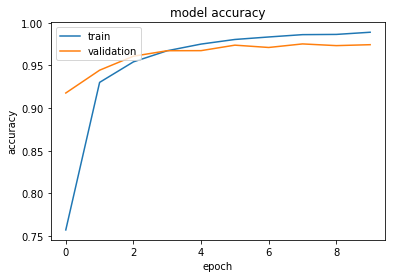

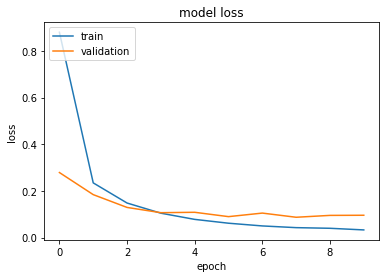

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

With a 97% validation accuracy score, I would say that we can come to trust this model, but a lot more iterations of training will be required before we can say that this model is significantly robust enough. But I would also include that a more nuanced technique of splitting the training, testing and validation sets could be used to significantly improve the model's ability to generalize. If the data contained within the training, testing, and validation datasets each contained data pointing to an equal distribution of labels, we would be able to better train the model, and given enough iterations, come up with a better validation accuracy.

One can get a deeper understanding of the model's accuracy towards unseen data by testing it against freshly hand drawn models by running the user facing app contained in the second directory. It is for this very purpose that the frontend application was implemented in the first place. For a majority of the tests that I had run by hand, I had found the model to perform significantly well. The training data used didnt seem to contain any outliers as such, like unlabelled data or deliberately misslabelled data, as the quality of the dataset has been verified by the data provider and other independent entities providing quality metrics for the same. The matter of sensitivity is also seemingly not a concern, as the model would not be able to train to anywhere near such a validation accuracy that we have observed, due to the learning rate being just right. However, as is the case here, a larger training period, combined with a more even data splitting may result in the model being able to generalize significantly better.